## Refugee Movement Around the World Analysis

https://github.com/rfordatascience/tidytuesday/blob/master/data/2023/2023-08-22/readme.md

In [1]:
import neo4j
import pandas as pd
from IPython.display import display, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [2]:
population = pd.read_csv('population.csv')

In [3]:
population[population['coa'] == 'USA'].head(2)

,year,coo_name,coo,coo_iso,coa_name,coa,coa_iso,refugees,asylum_seekers,returned_refugees,idps,returned_idps,stateless,ooc,oip,hst
3975,2010,Afghanistan,AFG,AFG,United States of America,USA,USA,1364,46,0,0,0,0,0,NaN,NaN
3976,2010,Albania,ALB,ALB,United States of America,USA,USA,6004,18,0,0,0,0,0,NaN,NaN


In [4]:
# Map country three letter codes to names (e.g., USA == United States of America) 
origin_country_dict = dict(zip(population['coo'], population['coo_name']))
asylum_country_dict = dict(zip(population['coa'], population['coa_name']))
country_name_dict = origin_country_dict | asylum_country_dict
print(f'{len(country_name_dict)} unique countries in dataset, with \
{len(origin_country_dict)} origin and {len(asylum_country_dict)} asylum.')

212 unique countries in dataset, with 210 origin and 189 asylum.


In [5]:
# Groupby to get overall refugee and asylum seeker counts
gb = population.groupby(['coo', 'coa'])['refugees', 'asylum_seekers'].sum()
gb.reset_index(inplace=True)
gb

/tmp/ipykernel_80/1076545059.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gb = population.groupby(['coo', 'coa'])['refugees', 'asylum_seekers'].sum()


,coo,coa,refugees,asylum_seekers
0,ABW,ABW,0,0
1,ABW,USA,0,7
2,AFG,AFG,0,0
3,AFG,ALB,19,0
4,AFG,ALG,0,5
...,...,...,...,...
7705,ZIM,TUR,6,113
7706,ZIM,UKR,0,35
7707,ZIM,USA,16123,7495
7708,ZIM,ZAM,53,5


## Connect, login, create driver, create session; with community edition, we can only use 1 database, the "neo4j" database

In [6]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [7]:
session = driver.session(database="neo4j")

## Functions to Manage neo4j data

In [8]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [9]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [10]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

## Nodes and Relationships
+ The cells need to be run in succession, creating nodes per country, before creating relationships
+ BUT, the nodes and relationships also need to be created in a _single query_, otherwise neo4j can't find
the country based on its name
+ NOTE: neo4j requires <font color='red'>names begin with a letter</font> (e.g., _2011_ throws error but _Y2011_ accepted)

<b><font color='red'>As of 4/3/2024 Dave turning off this section but retaining cells for reference.</font></b>

In [11]:
# my_neo4j_wipe_out_database()

In [12]:
# ### Loops to create:
#     # 1) node per country
#     # 2) relationships between origin and destination countries
# # NOTE: neo4j requires names begin with a letter
# query = 'CREATE'

In [13]:
# # Loop to create node per country
# # Template --> (usa:Country {name: 'United States of America'}),
# for c_code, c_name in origin_country_dict.items():
#     temp_string = "(" + c_code + ":Country {name: \"" + c_name + "\"}),"
#     query = query + temp_string

In [14]:
# # Loop to create relationships between countries
# # Skip where origin/destination country is the same
# # Skip where refugees count is 0
# relationships = []
# for i in range(0, len(gb)):
#     if gb.iloc[i]['coo'] != gb.iloc[i]['coa']:
#         relationships.append(
#             "("
#             + gb.iloc[i]['coo']
#             + ")-[:IS_CONNECTED_TO "
#             + "{refugees: " + str(gb.iloc[i]['refugees']) + ', '
#             + "asylum_seekers: " + str(gb.iloc[i]['asylum_seekers'])
#             + "}]->("
#             + gb.iloc[i]['coa']
#             + ")"
#         )

# query = query + ', '.join(relationships)

In [15]:
# # Preview first chars in query
# query[:200]

In [16]:
# # Run query to create node and relationships
# session.run(query)

In [17]:
# # Confirm that nodes and relationships created successfully
# my_neo4j_nodes_relationships()

## Graph 1 : Countries Accepting Refugees
Create a node for each country, with a one way relationship from the country the refugees are <b>emigrating from</b> to the country the refugees are <b>immigrating t</b>o, with the <b>weight of the relationship the number of refugees</b>.

In [57]:
my_neo4j_wipe_out_database()
query_refugees = "CREATE"

In [58]:
for c_code, c_name in origin_country_dict.items():
    temp_string = "(" + c_code + ":Country {name: \"" + c_name + "\"}),"
    query_refugees = query_refugees + temp_string

In [59]:
# Skip where origin/destination country is the same
# Skip where refugees count is 0
relationships_refugees = []
for i in range(0, len(gb)):
    if gb.iloc[i]['coo'] != gb.iloc[i]['coa'] and\
    gb.iloc[i]['refugees'] > 0:
        relationships_refugees.append(
            "("
            + gb.iloc[i]['coo']
            + ")-[:IS_CONNECTED_TO {weight: " + str(gb.iloc[i]['refugees'])
            # + "{refugees: " + str(gb.iloc[i]['refugees']) + ', '
            # + "asylum_seekers: " + str(gb.iloc[i]['asylum_seekers'])
            + "}]->("
            + gb.iloc[i]['coa']
            + ")"
        )

query_refugees = query_refugees + ', '.join(relationships_refugees)

In [60]:
relationships_refugees[0]

'(AFG)-[:IS_CONNECTED_TO {weight: 19}]->(ALB)'

In [61]:
session.run(query_refugees)

In [62]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Afghanistan,[Country]
1,Albania,[Country]
2,Algeria,[Country]
3,Andorra,[Country]
4,Angola,[Country]
...,...,...
206,Western Sahara,[Country]
207,Yemen,[Country]
208,Zambia,[Country]
209,Zimbabwe,[Country]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Afghanistan,[Country],IS_CONNECTED_TO,Albania,[Country]
1,Afghanistan,[Country],IS_CONNECTED_TO,Argentina,[Country]
2,Afghanistan,[Country],IS_CONNECTED_TO,Armenia,[Country]
3,Afghanistan,[Country],IS_CONNECTED_TO,Australia,[Country]
4,Afghanistan,[Country],IS_CONNECTED_TO,Austria,[Country]
...,...,...,...,...,...
5645,Zimbabwe,[Country],IS_CONNECTED_TO,Thailand,[Country]
5646,Zimbabwe,[Country],IS_CONNECTED_TO,Türkiye,[Country]
5647,Zimbabwe,[Country],IS_CONNECTED_TO,United Kingdom of Great Britain and Northern I...,[Country]
5648,Zimbabwe,[Country],IS_CONNECTED_TO,United States of America,[Country]


-------------------------
  Density: 0.3
-------------------------


### Graph 1, Algorithm 1: PageRank
+ PageRank would tell you who the most influential countries in granting asylum

In [32]:
# PageRank
query = "CALL gds.graph.drop('ds_graph', false)"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Country', 'IS_CONNECTED_TO', {relationshipProperties: 'weight'})"
session.run(query)

In [33]:
query = """

CALL gds.pageRank.stream('ds_graph', {
  maxIterations: $max_iterations,
  dampingFactor: $damping_factor
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY score DESC, name ASC
LIMIT 10

"""

max_iterations = 20
damping_factor = 0.85
my_neo4j_run_query_pandas(
    query,
    max_iterations=max_iterations,
    damping_factor=damping_factor
)

,name,page_rank
0,Canada,16.828460
1,United States of America,15.063493
2,Germany,13.544135
3,Rep. of Moldova,12.067899
4,Sweden,8.580532
5,Switzerland,7.344611
6,United Kingdom of Great Britain and Northern I...,5.961717
7,France,5.760596
8,Australia,5.540800
9,Ireland,4.598084


In [34]:
find_countries = ['CAN', 'USA']
syria_df = gb[gb['coo'] == 'SYR'].sort_values('refugees', ascending=False)
syria_df.insert(0, 'rank', range(1, 1 + len(syria_df)))
print('Total relationships:', len(syria_df))
display(syria_df.head(10))
print('Countries not in top 10 but of interest:')
for country in find_countries:
    display(syria_df[syria_df['coa'] == country])

Total relationships: 136


,rank,coo,coa,refugees,asylum_seekers
6574,1,SYR,TUR,29257140,1580
6515,2,SYR,LEB,9561936,1542
6506,3,SYR,JOR,6705304,3396
6491,4,SYR,GFR,3943021,545351
6503,5,SYR,IRQ,2486202,5933
6452,6,SYR,ARE,1318272,85
6565,7,SYR,SWE,877732,99194
6562,8,SYR,SUD,489265,1961
6456,9,SYR,AUS,394592,69064
6536,10,SYR,NET,275349,42689


Countries not in top 10 but of interest:


,rank,coo,coa,refugees,asylum_seekers
6467,33,SYR,CAN,14683,4867


,rank,coo,coa,refugees,asylum_seekers
6579,21,SYR,USA,72708,28993


## Graph 2 : Countries of Origin of Refugees
Create a node for each country, with a one way relationship from the country the refugees are <b>immmigrating to</b> from the country the refugees are <b>emmigrating from</b>, with the <b>weight of the relationship the number of refugees</b>.

In [ ]:
my_neo4j_wipe_out_database()
query_refugees = "CREATE"

In [ ]:
for c_code, c_name in country_name_dict.items():
    temp_string = "(" + c_code + ":Country {name: \"" + c_name + "\"}),"
    query_refugees = query_refugees + temp_string

In [ ]:
# Skip where origin/destination country is the same
# Skip where refugees count is 0
# NOTE: Same loop as above, but 'coo' and 'coa' are flipped
relationships_refugees = []
for i in range(0, len(gb)):
    if gb.iloc[i]['coo'] != gb.iloc[i]['coa'] and\
    gb.iloc[i]['refugees'] > 0:
        relationships_refugees.append(
            "("
            + gb.iloc[i]['coa']
            + ")-[:IS_CONNECTED_TO {weight: " + str(gb.iloc[i]['refugees'])
            + "}]->("
            + gb.iloc[i]['coo']
            + ")"
        )

query_refugees = query_refugees + ', '.join(relationships_refugees)

In [ ]:
relationships_refugees[0]

In [ ]:
session.run(query_refugees)

In [ ]:
#my_neo4j_nodes_relationships()

### Graph 2, Algorithm 1: PageRank
+ PageRank would tell you who the most influential countries in creating refugees

In [ ]:
# PageRank
query = "CALL gds.graph.drop('ds_graph', false)"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Country', 'IS_CONNECTED_TO', {relationshipProperties: 'weight'})"
session.run(query)

In [ ]:
query = """


CALL gds.pageRank.stream('ds_graph', {
  maxIterations: $max_iterations,
  dampingFactor: $damping_factor
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY score DESC, name ASC
LIMIT 10

"""
# source = "Syrian Arab Rep."

max_iterations = 20
damping_factor = 0.85

my_neo4j_run_query_pandas(
    query,
#     source=source,
    max_iterations=max_iterations,
    damping_factor=damping_factor
)

In [ ]:
find_countries = ['TUR', 'LEB', 'JOR']
syria_df = gb[gb['coa'] == 'SYR'].sort_values('refugees', ascending=False)
syria_df.insert(0, 'rank', range(1, 1 + len(syria_df)))
print('Total relationships:', len(syria_df))
display(syria_df.head(10))
print('Countries not in top 10 but of interest:')
for country in find_countries:
    display(syria_df[syria_df['coo'] == country])

### There were two Graph 1 Algorithm 1's, they were the same so I removed the duplicate but im not sure which this query goes for

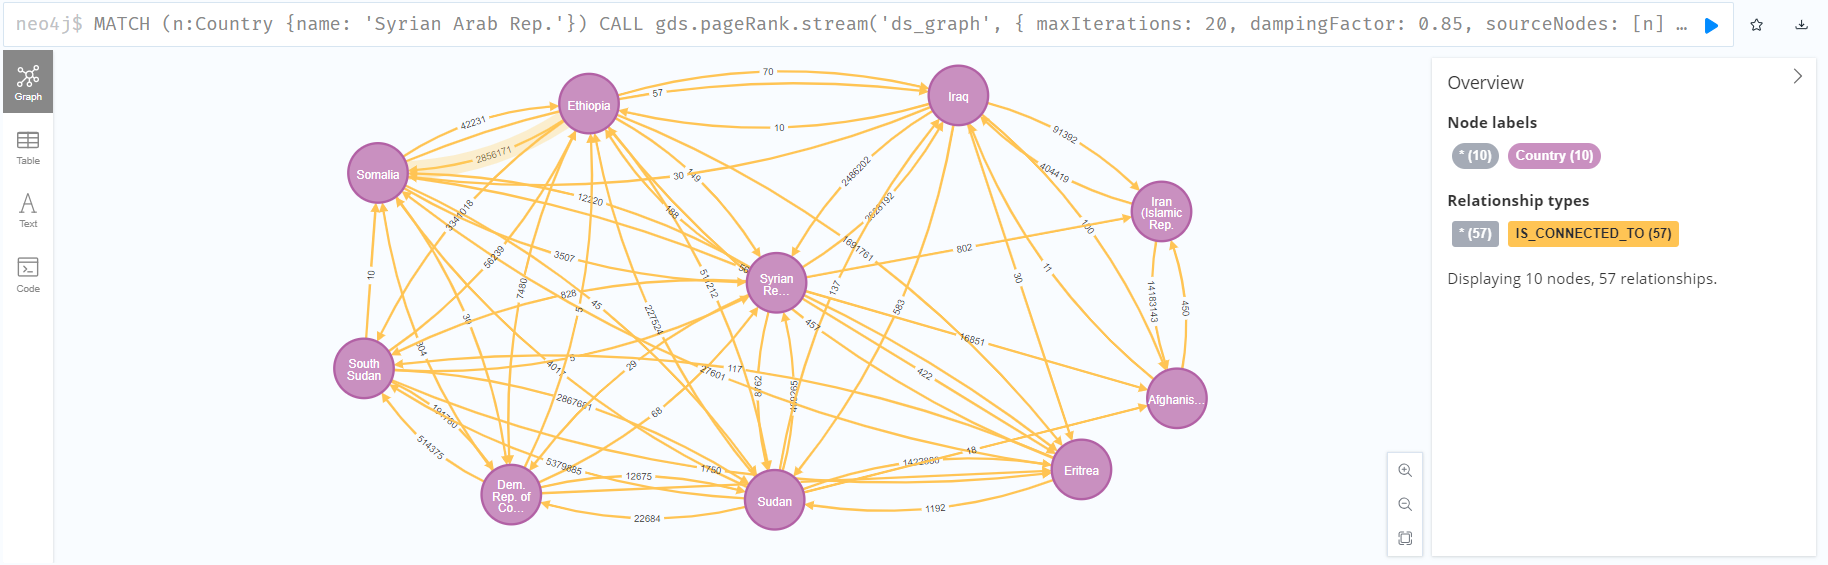

In [29]:
### Query for neo4j dashboard to yield the below graph:
'''
MATCH (n:Country {name: 'Syrian Arab Rep.'})
CALL gds.pageRank.stream('ds_graph', {
    maxIterations: 20,
    dampingFactor: 0.85,
    sourceNodes: [n]
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId), score as page_rank
ORDER BY score DESC
LIMIT 10
'''
Image(filename='viz/syria_graph1.png')

### Graph 1, Algorithm 2: PageRank Personalized for Syria
+ I am confused by this because I did not thikn SYR would be on this list? I may be misinterpreting but I thought we were trying to see 

In [35]:
# PageRank
query = "CALL gds.graph.drop('ds_graph', false)"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Country', 'IS_CONNECTED_TO', {relationshipProperties: 'weight'})"
session.run(query)

In [37]:
query = """

MATCH (n:Country {name: 'Syrian Arab Rep.'})
CALL gds.pageRank.stream('ds_graph', {
  maxIterations: $max_iterations,
  dampingFactor: $damping_factor,
  sourceNodes: [n]
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY score DESC, name ASC
LIMIT 20

"""
source = "Syrian Arab Rep."

max_iterations = 20
damping_factor = 0.85

my_neo4j_run_query_pandas(
    query,
    source=source,
    max_iterations=max_iterations,
    damping_factor=damping_factor
)

,name,page_rank
0,Syrian Arab Rep.,0.150744
1,Canada,0.070357
2,United States of America,0.060052
3,Germany,0.057188
4,Rep. of Moldova,0.051001
5,Sweden,0.036640
6,Switzerland,0.031510
7,France,0.024114
8,United Kingdom of Great Britain and Northern I...,0.023938
9,Australia,0.021621


In [ ]:
### Query for neo4j dashboard to yield the below graph:
'''
MATCH (n)
CALL gds.pageRank.stream('ds_graph', {
    maxIterations: 20,
    dampingFactor: 0.85,
    sourceNodes: [n]
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId), score as page_rank
ORDER BY score DESC
LIMIT 20
'''
Image(filename='viz/syria_graph2.png')

### Graph 1, Algorithm 3: Minimum Spanning Tree
+ Select the top X refugee creators, and for each top refugee creator, run a Minimum Spanning Tree on the first graph to see how refugees flow to the top asylum granters
+ the top 3 refugee creators (from Graph 2, Algorithm 1) are 
    + Graph 1, Algorithm 3.1 Syrian Arab Rep. 
    + Graph 2, Algorithm 3.2 Iraq
    + Graph 3, Algorithm 3.3 Sudan

In [63]:
# Graph 1, Algorithm 3.1 Syrian Arab Rep. 
def my_neo4j_wipe_out_mst_relationships():
    "wipe out mst relationships"
    
    query = "match (node)-[relationship:MST]->() delete relationship"
    session.run(query)

In [64]:
my_neo4j_wipe_out_mst_relationships()

In [65]:
# query = "CALL gds.graph.drop('ds_graph', false)"
# session.run(query)

# query = """

# CALL gds.graph.project('ds_graph', 'Country', 
#                         {
#                             TRACK: {
#                                 properties: 'refugees',
#                                 orientation: 'UNDIRECTED'
#                             }
#                         }
#                        )

# """

# session.run(query)

In [66]:
query = """

MATCH (n:Country {name: $source})
CALL gds.beta.spanningTree.write('ds_graph',
                                          {sourceNode: id(n),
                                           relationshipWeightProperty: 'refugees',
                                           writeProperty: 'writeCost',
                                           writeRelationshipType: 'MST'
                                          }
                                         )
YIELD preProcessingMillis, computeMillis, writeMillis, effectiveNodeCount
RETURN preProcessingMillis, computeMillis, writeMillis, effectiveNodeCount;

"""

source = "Syrian Arab Rep."

my_neo4j_run_query_pandas(query, source=source)

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.beta.spanningTree.write`: Caused by: java.lang.IllegalArgumentException: Source node does not exist in the in-memory graph: `225`}

In [67]:
query = """

MATCH path = (n:Country {name: $source})-[:MST*]-()
WITH relationships(path) AS rels
UNWIND rels AS rel
WITH DISTINCT rel AS rel
RETURN startNode(rel).name AS source, endNode(rel).name AS destination, rel.writeCost AS cost

"""

source = "Syrian Arab Rep."

my_neo4j_run_query_pandas(query, source=source)

,source,destination,cost
